In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os
import sys
import re
from time import process_time
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from apachelogs import LogParser

## CLF Processing for Analytics
Local processing of combined log format (CLF) into forms that are more usable for data analysis.

- `apachelogs` package used to parse logs. 

This isn't the most efficient code, but list comprehension usage speeds things up so a fairly large amount of logs can be processed relatively quickly (for imaging node, this notebook code can process roughly 2.4M lines of http logs or about 30 days worth in just under 3 minutes).

In [81]:
data_dir = Path('/Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/')
column_names = ['ip', 'identd', 'userid', 'datetime', 'request', 'status', 'size', 'referer', 'user_agent']
log_files = sorted([data_dir / f for f in os.listdir(data_dir)])
log_files = log_files[:31] # Just deal with a month's worth for now.
df_logs = pd.DataFrame(columns=column_names)
parser = LogParser("%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\"")

In [82]:
def parse_line(line):
    """Parse a line from log and return a list with log entries in CLF order"""
    parsed = parser.parse(line)
    datetime = parsed.request_time
    parsed_line = [parsed.remote_host, 
                   parsed.remote_logname,
                   parsed.remote_user,
                   datetime,
                   parsed.request_line, 
                   parsed.final_status,
                   parsed.bytes_sent,
                   parsed.headers_in["Referer"],
                   parsed.headers_in["User-Agent"]]
    return parsed_line


def parse_file(file):
    log_file = open(file)
    lines = log_file.readlines()
    log_entries = list(map(parse_line, lines))
    df_logs = pd.concat([df_logs, pd.DataFrame(log_entries, columns=column_names)])
    print(df_logs.shape[0])

In [83]:
%%time
for file in log_files:
    log_file = open(log_files[0])
    lines = log_file.readlines()
    log_entries = list(map(parse_line, lines))
    df_logs = pd.concat([df_logs, pd.DataFrame(log_entries, columns=column_names)])
    print(f"Completed processing file {file}")

Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-01.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-02.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-03.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-04.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-05.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-06.log
Completed processing file /Users/kaipak/datasets/pds/pds_logs/report_service/logs/final/img/img-pdsimage-http/ssl_access_2020-12-07.log
Completed processing file /Users/kaipak/datasets

In [84]:
df_logs.describe()

,ip,identd,userid,datetime,request,status,size,referer,user_agent
count,2442025,0,0,2442025,2442025,2442025,1745393.0,136493,2427672
unique,3077,0,0,49648,70811,8,13933.0,749,1573
top,64.62.202.73,NaN,NaN,2020-12-01 19:50:16-07:00,GET /favicon.ico HTTP/1.1,200,5200.0,https://www.google.com/,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
freq,520087,NaN,NaN,372,14260,1668513,100409.0,79918,660517


In [85]:
df_logs.head()

,ip,identd,userid,datetime,request,status,size,referer,user_agent
0,185.191.171.2,None,None,2020-12-01 04:28:47-07:00,GET /archive/co-e_v_j_s-vims-2-qube-v1.0/covim...,200,276992.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
1,185.191.171.25,None,None,2020-12-01 04:28:48-07:00,GET /cdroms/Viking_Orbiter/vo_1012/f086axx/f08...,200,462876.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
2,185.191.171.12,None,None,2020-12-01 04:28:48-07:00,GET /data/co-e_v_j_s-vims-2-qube-v1.0/covims_0...,200,76928.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
3,157.55.39.170,None,None,2020-12-01 04:28:49-07:00,GET /archive/a15c-l-mc-2-scanned-images-v1.0/A...,304,NaN,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,5.255.253.103,None,None,2020-12-01 04:28:49-07:00,GET /Missions/Viking_Orbiter/vo_1058/browse/f3...,200,82500.0,None,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...


In [87]:
%%time
df_logs.reset_index().to_feather('foo.feather')

CPU times: user 3.3 s, sys: 376 ms, total: 3.68 s
Wall time: 3.35 s


In [88]:
df_sum = df_logs.groupby(by='user_agent').size().to_frame('count').reset_index()

In [89]:
df_sum.sort_values(by='count', ascending=False, inplace=True)
df_sum.head()

,user_agent,count
1421,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,660517
1414,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,574306
1401,Mozilla/5.0 (compatible; +centuryb.o.t9[at]gma...,520087
1418,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,201686
380,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,185411


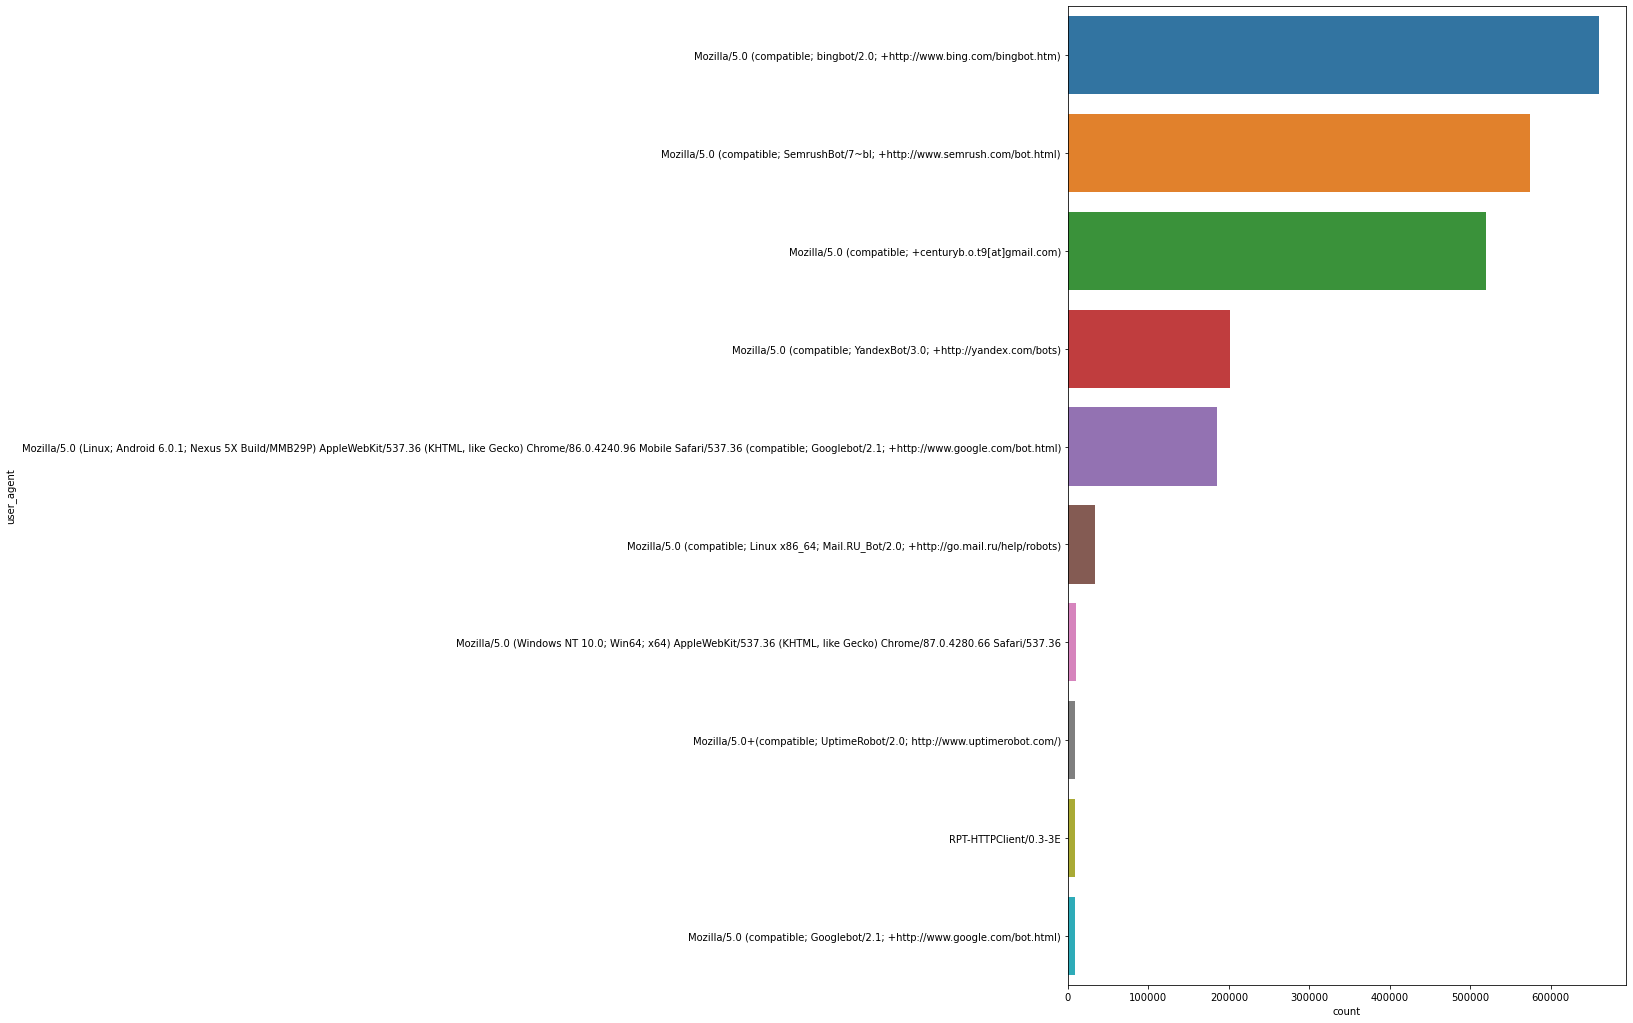

In [91]:
fig, ax = plt.subplots(figsize=(10,18))
barplot = sns.barplot(data=df_sum[:10], y='user_agent', x='count', orient='h', ax=ax)

# Test Class Code
Exported above code to handy class so we can use elsewhere.

In [92]:
sys.path.append('../src/')
from clf_parser import CLFParse

In [93]:
parser = CLFParse(log_files)

In [95]:
parser.parse_files()

Logfiles list contains 31 files.
10 files have been processed. 1.03 minutes elapsed
20 files have been processed. 2.82 minutes elapsed
30 files have been processed. 4.52 minutes elapsed
5.98m to process log files.


In [96]:
df_logs

,ip,identd,userid,datetime,request,status,size,referer,user_agent
0,185.191.171.2,None,None,2020-12-01 04:28:47-07:00,GET /archive/co-e_v_j_s-vims-2-qube-v1.0/covim...,200,276992.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
1,185.191.171.25,None,None,2020-12-01 04:28:48-07:00,GET /cdroms/Viking_Orbiter/vo_1012/f086axx/f08...,200,462876.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
2,185.191.171.12,None,None,2020-12-01 04:28:48-07:00,GET /data/co-e_v_j_s-vims-2-qube-v1.0/covims_0...,200,76928.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
3,157.55.39.170,None,None,2020-12-01 04:28:49-07:00,GET /archive/a15c-l-mc-2-scanned-images-v1.0/A...,304,NaN,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,5.255.253.103,None,None,2020-12-01 04:28:49-07:00,GET /Missions/Viking_Orbiter/vo_1058/browse/f3...,200,82500.0,None,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
...,...,...,...,...,...,...,...,...,...
78770,13.66.139.67,None,None,2020-12-02 03:36:41-07:00,GET /cdroms/Viking_Orbiter/vo_1016/f372axx/f37...,200,398308.0,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
78771,13.66.139.67,None,None,2020-12-02 03:36:41-07:00,GET /data/lro-l-lamp-2-edr-v1.0/LROLAM_0031/DA...,200,6869.0,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
78772,185.191.171.17,None,None,2020-12-02 03:36:42-07:00,GET /Missions/Viking_Orbiter/vo_1010/f034axx/f...,200,558454.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
78773,185.191.171.19,None,None,2020-12-02 03:36:43-07:00,GET /Individual_Investigations/multi_galileo_n...,200,1125602.0,None,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...
